## Modules à importer

In [1]:
import sep
import math
import scipy
import pickle
import random
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import iminuit as im
import ipywidgets as ipw
import matplotlib.pyplot as plt

from variaIa import tools
from importlib import reload
from pymage import panstarrs
from pshost import massmeasure
from variaIa import stretchevol
from variaIa import massevol
from variaIa.tools import surveys, df_cons, df_nc, df_c, df_full, z_max
from IPython.display import display, HTML, Latex
from matplotlib.patches import Ellipse
from astropy.cosmology import Planck15 as cosmo
from astropy import units

display(HTML("<style>.container { width:100% !important; }</style>"))

### Définition des données à montrer

In [2]:
btw = ipw.Checkbox(
    value=False,
    description='btw')
after = ipw.Checkbox(
    value=False,
    description='After')

def set_survey(cons, su):
    global df
    if su == 'All':
        df = df_cons(cons)
    elif 'n' in su:
        df = df_cons(cons)[df_cons(cons)['survey'] != su.split('n')[-1]]
    else:
        df = df_cons(cons)[df_cons(cons)['survey'] == su]
    return df

int_set_su = ipw.interactive(set_survey, cons=tools.cons, su=tools.su)
display(ipw.HBox([int_set_su, btw, after]))

smap = plt.cm.get_cmap('cividis')
colors = {'SNF': plt.cm.binary(0.9),
          'low-z': (1, 0, 0),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99),  # for cividis
          #'HST': smap(300)}  # for viridis
          'All': (255/255, 51/255, 0/255)}

def alphacolors(alpha, survey):
    return(colors[survey][0], colors[survey][1], colors[survey][2], alpha)

df_nHST = df_nc[df_nc['survey'] != 'HST']

## Low-z ra, dec and zcmb to extract

In [4]:
d = pd.read_csv('../../../Data/sne/data_cheat.csv', sep=' ')#, index_col='CID')
todl = d[d['IDSURVEY'].isin([5,
                             61, 62, 63, 64, 65, 66])][['CID',
                                                        'RA',
                                                        'DECL',
                                                        'zCMB',
                                                        'HOST_LOGMASS',
                                                        'HOST_LOGMASS_ERR']].values
# Indexes 131 and 142 couldn't be recovered with PS1Target
CID = np.concatenate((todl[:, 0][:131], todl[:, 0][132:142],
                    todl[:, 0][143:]), axis=None)
ra = np.concatenate((todl[:, 1][:131], todl[:, 1][132:142],
                    todl[:, 1][143:]), axis=None)
dec = np.concatenate((todl[:, 2][:131], todl[:, 2][132:142],
                     todl[:, 2][143:]), axis=None)
zcmb = np.concatenate((todl[:, 3][:131], todl[:, 3][132:142],
                      todl[:, 3][143:]), axis=None)
mass = np.concatenate((todl[:, 4][:131], todl[:, 4][132:142],
                      todl[:, 4][143:]), axis=None)
mass_err = np.concatenate((todl[:, 5][:131], todl[:, 5][132:142],
                          todl[:, 5][143:]), axis=None)
lowz_dict = {'CID': CID,
             'ra': ra,
             'dec': dec,
             'zcmb': zcmb,
             'hg_mass_sco': mass,
             'hg_masserr_sco': mass_err}
lowz_df = pd.DataFrame.from_dict(lowz_dict)

## Same for SNF

In [9]:
d_snf = pd.read_csv('../../../Data/sne/lssfr_paper_full_sntable.csv', sep=',')

name = d_snf['name'].values
ra = d_snf['target.ra'].values
dec = d_snf['target.dec'].values
zcmb = d_snf['host.zcmb'].values

In [19]:
tomat_dict = {'name': d_snf['name'],
              'ra': d_snf['target.ra'],
              'dec': d_snf['target.dec'],
              'mass': snf_mass.T[0],
              'mass_err_down': snf_mass.T[1],
              'mass_err_up': snf_mass.T[2]}
tomat_df = pd.DataFrame.from_dict(tomat_dict)
pickle.dump(tomat_df, open('../../../Data/mass/tomat', 'wb'))

In [13]:
with open('../../../Data/mass/snf_mass', 'rb') as f:
    snf_mass = pickle.load(f)

## Set cutout size depending on redshift

d_Mpc_rad = cosmo.angular_diameter_distance(zcmb)
rad_to_arcsec = (np.pi/180*3600)**(-1)
d_Mpc_per_arcsec = d_Mpc_rad*rad_to_arcsec
d_Mpc_per_pixel = d_Mpc_per_arcsec*pix_arc
nb_pix = np.ceil((100./d_Mpc_per_pixel).value)
redownload = nb_pix > 240

### Advanced cutout selection using HG ellipses parameters

### First study the data

In [20]:
#with open('../../../Data/mass/mmcls_lowz', 'rb') as f:
#    mmcls_lowz = pickle.load(f)
with open('../../../Data/mass/mmcls_snf', 'rb') as f:
    mmcls_snf = pickle.load(f)

In [21]:
hgell_nora = []
hgell_pyma = []
for i in range(len(mmcls_snf)):
    hgell_nora.append(mmcls_snf[i].hg_ellipse)
    hgell_pyma.append(mmcls_snf[i].target.get_nearest_ellipse())

hgell_nora = np.asarray(hgell_nora)
hgell_pyma = np.asarray(hgell_pyma)
hgell_diff = hgell_nora - hgell_pyma

if int(np.sum(hgell_nora == hgell_pyma)/5) == len(hgell_nora):
    print('Hell yeah')
else:
    print('Stamps to check:',
          np.where(np.sum(hgell_nora == hgell_pyma, axis=1) != 5)[0])

Stamps to check: [  6   7  44  53 101 136]


In [23]:
mmcls_snf[0].target.get_nearest()

(array([3]), array([1.30190411]))

In [30]:
mmcls_snf[0].target.get_nearest_ellipse()

array([ 76.9089359 , 116.10509622,  27.95238495,  19.53148651,
        -1.25106764])

In [252]:
mmcls_snf[19].target.sep.sepobjects.pixel_to_coords(*mmcls_snf[19].hg_ellipse[:2])

array([247.58215307,  21.08560771])

In [266]:
mmcls_snf[31].target.get_nearest_distance(source='galcat')

array([1.5309998])

In [265]:
mmcls_snf[21].target.get_nearest_catdata(source='galcat')[['objID',
                                                          'raStack',
                                                          'decStack',
                                                          'gKronMag',
                                                          'rKronMag',
                                                          'iKronMag',
                                                          'zKronMag',
                                                          'gKronMagErr',
                                                          'rKronMagErr',
                                                          'iKronMagErr',
                                                          'zKronMagErr']]

,objID,raStack,decStack,gKronMag,rKronMag,iKronMag,zKronMag,gKronMagErr,rKronMagErr,iKronMagErr,zKronMagErr
64,120503235216918770,323.5217,10.423559,18.743099,18.706699,18.2411,18.2183,0.010367,0.007975,0.005884,0.014087


In [256]:
mmcls_snf[31].target.catdata.loc[mmcls_snf[31].target.get_nearest_galcatid()[0]][['raStack', 'decStack', 'gKronMag', 'rKronMag']]

raStack     355.447
decStack    -3.6673
gKronMag     15.191
rKronMag    14.2557
Name: 12, dtype: object

In [259]:
mmcls_snf[31].target.get_nearest_catdata(source='galcat')[['gKronMag', 'rKronMag']]

,gKronMag,rKronMag
12,15.191,14.2557


In [247]:
mmcls_snf[31].target.catdata.loc[12][['raStack', 'decStack']]

raStack     355.447
decStack    -3.6673
Name: 12, dtype: object

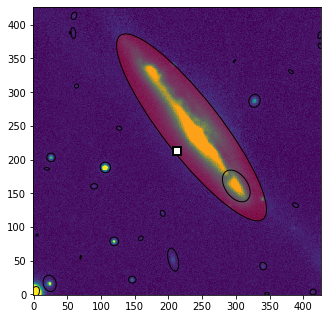

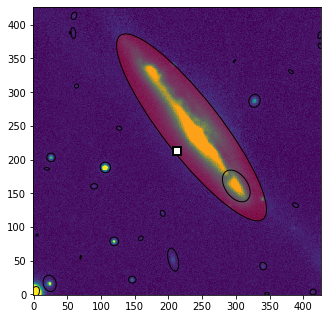

In [241]:
mmcls_snf[31].show()

In [373]:
tomat_dict = {'objID': [],
              'raStack': [],
              'decStack': [],
              'gKronMag': [],
              'rKronMag': [],
              'iKronMag': [],
              'zKronMag': [],
              'gKronMagErr': [],
              'rKronMagErr': [],
              'iKronMagErr': [],
              'zKronMagErr': []}
tomat_df = pd.DataFrame.from_dict(tomat_dict)
tomat_df

,objID,raStack,decStack,gKronMag,rKronMag,iKronMag,zKronMag,gKronMagErr,rKronMagErr,iKronMagErr,zKronMagErr


In [377]:
tomat_df

,objID,raStack,decStack,gKronMag,rKronMag,iKronMag,zKronMag,gKronMagErr,rKronMagErr,iKronMagErr,zKronMagErr
0,1.118334e+17,340.125928,3.195065,20.9596,20.2521,19.681601,19.592199,0.036792,0.023291,0.016271,0.042605
1,9.437211e+16,210.562853,-11.355716,-999.0000,-999.0000,-999.000000,21.443501,-999.000000,-999.000000,-999.000000,0.157367


In [339]:
pickle.dump(tomat_df, open('../../../Data/mass/tomat_df', 'wb'))

In [343]:
for i in range(len(mmcls_snf)):
    mmcls_snf[i].target.download_catalog(rdeg=1/60)

In [371]:
for i in range(len(mmcls_snf)):
    mmcls_snf[i].target.match_sepcat(distmatch=60*units.arcsec)

In [364]:
mmcls_snf[2].target.get_nearest_distance(source='galcat')

array([5.49226561])

In [386]:
mmcls_snf[1].target.galcat.data.iloc[mmcls_snf[1].target.get_nearest_galcatid()[0]]

Ab             0.470347
AbErr          0.000808
Chisq          6.496970
Dec          -11.341924
DecErr         0.000315
Mag           18.435101
MagErr         0.000618
Phi           39.205299
PhiErr         0.003045
Ra           210.566269
Radius         2.446480
RadiusErr      0.004090
RaErr          0.000326
Name: 24, dtype: float64

In [378]:
mmcls_snf[1].target.get_nearest_galcatid()

Int64Index([17], dtype='int64')

In [376]:
mmcls_snf[1].target.get_nearest_catdata(source='galcat')

,objInfoFlag,objID,objName,qualityFlag,raStack,decStack,raStackErr,decStackErr,raMean,decMean,raMeanErr,decMeanErr,ng,nr,ni,nz,ny,gPSFMag,rPSFMag,iPSFMag,zPSFMag,yPSFMag,gPSFMagErr,rPSFMagErr,iPSFMagErr,zPSFMagErr,yPSFMagErr,gKronMag,rKronMag,iKronMag,zKronMag,yKronMag,gKronMagErr,rKronMagErr,iKronMagErr,zKronMagErr,yKronMagErr,gApMag,rApMag,iApMag,zApMag,yApMag,gApMagErr,rApMagErr,iApMagErr,zApMagErr,yApMagErr,sepid,sepdist
17,1343750144,94372105628533518,PSO J210.5629-11.3557,160,210.562853,-11.355716,0.001,0.001,210.562853,-11.355716,0.001,0.001,0,0,0,0,0,23.473499,-999.0,23.7609,22.2131,-999.0,0.212329,1.39577,0.299961,0.155723,0.644267,-999.0,-999.0,-999.0,21.443501,-999.0,-999.0,-999.0,-999.0,0.157367,-999.0,21.9002,-999.0,-999.0,24.850599,-999.0,0.009546,0.007373,0.010615,0.034729,0.010042,13.0,51.619955


In [375]:
for i in range(len(mmcls_snf)):
    print(i)
    toadd = mmcls_snf[i].target.get_nearest_catdata(source='galcat')[['objID',
                                                                      'raStack',
                                                                      'decStack',
                                                                      'gKronMag',
                                                                      'rKronMag',
                                                                      'iKronMag',
                                                                      'zKronMag',
                                                                      'gKronMagErr',
                                                                      'rKronMagErr',
                                                                      'iKronMagErr',
                                                                      'zKronMagErr']]
    tomat_df = tomat_df.append(toadd, ignore_index=True)

0
1
2


KeyError: "None of [Int64Index([73], dtype='int64')] are in the [index]"

In [338]:
for i in range(len(mmcls_snf)):
    print(f'{i}:', mmcls_snf[i].target.get_nearest_catdata(source='galcat')[['objID',
                                                                      'raStack',
                                                                      'decStack',
                                                                      'gKronMag',
                                                                      'rKronMag',
                                                                      'iKronMag',
                                                                      'zKronMag',
                                                                      'gKronMagErr',
                                                                      'rKronMagErr',
                                                                      'iKronMagErr',
                                                                      'zKronMagErr']])

0:                  objID     raStack  decStack  gKronMag   rKronMag   iKronMag  \
52  111823401101109480  340.110118  3.190857   19.6478  19.000099  18.647699   

     zKronMag  gKronMagErr  rKronMagErr  iKronMagErr  zKronMagErr  
52  18.607201     0.009138     0.005641     0.005235     0.011725  
1:                 objID     raStack   decStack  gKronMag  rKronMag  iKronMag  \
17  94382105626710921  210.562702 -11.349547   15.8153   15.3629   15.0554   

    zKronMag  gKronMagErr  rKronMagErr  iKronMagErr  zKronMagErr  
17   14.9177     0.002183     0.001854     0.001314     0.002432  
2:                  objID     raStack   decStack  gKronMag  rKronMag  iKronMag  \
73  144041750215406351  175.021991  30.038145   18.4363   17.7971   17.5529   

    zKronMag  gKronMagErr  rKronMagErr  iKronMagErr  zKronMagErr  
73   17.4683     0.009662      0.00748     0.003889     0.007264  
3:                 objID     raStack  decStack   gKronMag  rKronMag  iKronMag  \
9  105763478564742172  347.85

In [330]:
mmcls_snf[24].target.get_nearest_catdata(source='galcat')['zKronMag']

20    13.9824
Name: zKronMag, dtype: float64

In [332]:
mmcls_snf[25].hg_ellipse

array([187.40842631, 250.14585309,  49.96670532,  45.7064209 ,
        -0.72958732])

In [333]:
mmcls_snf[25].target.get_nearest_ellipse()

array([187.40842631, 250.14585309,  49.96670532,  45.7064209 ,
        -0.72958732])

In [336]:
mmcls_snf[25].target.get_nearest_catdata(source='galcat')

,objInfoFlag,objID,objName,qualityFlag,raStack,decStack,raStackErr,decStackErr,raMean,decMean,...,zSerNu,zSerNuErr,zSerPhi,zSerPhiErr,zSerRa,zSerRadius,zSerRadiusErr,zSerRaErr,zstackDetectID1,zstackImageID1
125,144179200,131993405370305825,PSO J340.5371+19.9959,17,340.537145,19.995934,0.001,0.001,340.537145,19.995934,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2.523058e+18,3881215.0


In [334]:
mmcls_snf[25].target.sep.sepobjects.pixel_to_coords(*mmcls_snf[25].hg_ellipse[:2])

array([340.54377976,  19.99705169])

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/astrobject-0.8.6-py3.7.egg/astrobject/utils/mpladdon.py:731: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


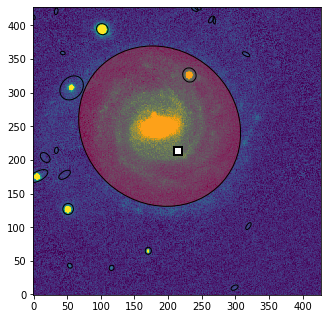

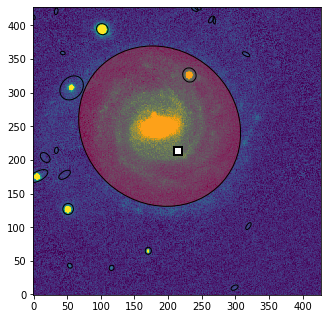

In [335]:
mmcls_snf[25].show()

In [304]:
mmcls_snf[26].target.get_nearest_catdata(source='galcat')['rPSFMag']

Series([], Name: rPSFMag, dtype: float64)

In [308]:
mmcls_snf[26].hg_ellipse

array([130.22042589, 134.14450926,  21.24668503,   9.32534218,
         1.14749444])

In [307]:
mmcls_snf[26].target.get_nearest_ellipse()

array([130.22042589, 134.14450926,  21.24668503,   9.32534218,
         1.14749444])

In [323]:
mmcls_snf[26].target.get_nearest_sepid()

array([4])

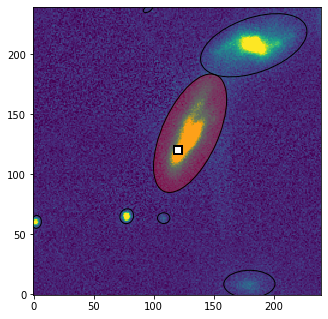

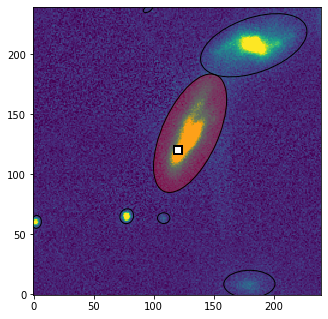

In [303]:
mmcls_snf[26].show()

In [45]:
mmcls_snf[0].target.match_sepcat()

In [56]:
mmcls_snf[0].target.catdata[mmcls_snf[0].target.catdata['sepid'] == 3.0]

,objInfoFlag,objID,objName,qualityFlag,raStack,decStack,raStackErr,decStackErr,raMean,decMean,...,zSerPhi,zSerPhiErr,zSerRa,zSerRadius,zSerRadiusErr,zSerRaErr,zstackDetectID1,zstackImageID1,sepid,sepdist
76,528801792,111833401192587327,PSO J340.1193+03.1974,63,340.119274,3.197396,0.001,0.001,340.119298,3.197381,...,86.371300,0.000023,340.119263,2.25212,0.000022,0.000006,2.523051e+18,3857186.0,3.0,0.655038
77,528801792,111833401192587327,PSO J340.1193+03.1974,63,340.119274,3.197396,0.001,0.001,340.119298,3.197381,...,87.376801,0.000024,340.119263,2.22377,0.000022,0.000006,2.523051e+18,3857187.0,3.0,0.655038
78,528801792,111833401192587327,PSO J340.1193+03.1974,63,340.119274,3.197396,0.001,0.001,340.119298,3.197381,...,86.371300,0.000023,340.119263,2.25212,0.000022,0.000006,2.523051e+18,3857186.0,3.0,0.655038
79,528801792,111833401192587327,PSO J340.1193+03.1974,63,340.119274,3.197396,0.001,0.001,340.119298,3.197381,...,87.376801,0.000024,340.119263,2.22377,0.000022,0.000006,2.523051e+18,3857187.0,3.0,0.655038
80,528801792,111833401192587327,PSO J340.1193+03.1974,63,340.119274,3.197396,0.001,0.001,340.119298,3.197381,...,86.371300,0.000023,340.119263,2.25212,0.000022,0.000006,2.523051e+18,3857186.0,3.0,0.655038
81,528801792,111833401192587327,PSO J340.1193+03.1974,63,340.119274,3.197396,0.001,0.001,340.119298,3.197381,...,87.376801,0.000024,340.119263,2.22377,0.000022,0.000006,2.523051e+18,3857187.0,3.0,0.655038
82,528801792,111833401192587327,PSO J340.1193+03.1974,63,340.119274,3.197396,0.001,0.001,340.119298,3.197381,...,86.371300,0.000023,340.119263,2.25212,0.000022,0.000006,2.523051e+18,3857186.0,3.0,0.655038
83,528801792,111833401192587327,PSO J340.1193+03.1974,63,340.119274,3.197396,0.001,0.001,340.119298,3.197381,...,87.376801,0.000024,340.119263,2.22377,0.000022,0.000006,2.523051e+18,3857187.0,3.0,0.655038


In [26]:
mmcls_snf[0].hg_ellipse

array([ 76.9089359 , 116.10509622,  27.95238495,  19.53148651,
        -1.25106764])

In [6]:
lowz_df['hg_mass_nr'] = [mmcls_lowz[i].hg_mass[0] for i in range(len(lowz_df))]
lowz_df['hg_masserr_nr_down'] = [mmcls_lowz[i].hg_mass[1] for i in range(len(lowz_df))]
lowz_df['hg_masserr_nr_up'] = [mmcls_lowz[i].hg_mass[2] for i in range(len(lowz_df))]

In [7]:
pickle.dump(lowz_df, open('../../../Data/sne/lowz_df', 'wb'))

In [6]:
#mmcls_snf = []
for i in range(len(ra)):
    print(i)
    #if redownload[i]:
    #    mmcls_lowz[i].update(size=needed_size[i])
    #    mmcls_lowz[i].get_hostgalaxy()
    #    mmcls_lowz[i].get_hostgalaxy_params()
    #mm = massmeasure.MassMeasure(ra[i], dec[i], zcmb[i], snfcls[i].imgcutout)
    #mm.get_hostgalaxy_params()
    #mmcls_snf.append(mm)
    mmcls_lowz[i].get_hostgalaxy_params()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51


/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/astrobject-0.8.6-py3.7.egg/astrobject/collections/photodiagnostics.py:586: UserWarning: 10000/10000 color samplers will be changed to the prior distribution as they have negative flux


52
53
54
55
56


/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/astrobject-0.8.6-py3.7.egg/astrobject/utils/tools.py:134: RuntimeWarning: invalid value encountered in log10


57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169


In [218]:
#pickle.dump(mmcls_lowz, open('../../../Data/mass/mmcls_lowz', 'wb'))
pickle.dump(mmcls_snf, open('../../../Data/mass/mmcls_snf', 'wb'))

#### Get current sizes

In [5]:
current_size = []
for i in range(len(zcmb)):
    current_size.append(len(mmcls_lowz[i].target.imgcutout['r'].data))

In [16]:
increment = np.array(needed_size)-np.array(current_size)

In [125]:
increment

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  20,   0,   0,   0,   0,   0,   0,   0,
         0,  44,   0,   0,   0,   0,   0,   0,  51,   0,   0,   0,  99,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        43,   0,   0,   0,  64,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  30,
         8,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 171,
         6,   0,   0,   0,   0,   0,   0,  62,   0,   0, 256,   0,   0,
         0,   0,   0,  24,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0])

In [17]:
increment[redownload]

array([ 30, 140,  13,  28, 171,   6,  62, 256,  24])

#### Get ellipses of all host galaxies

In [6]:
all_hg_ell_params = []
for i in range(len(zcmb)):
    all_hg_ell_params.append(mmcls_lowz[i].hg_ellipse)
    
scaleup = 3

all_hg_ell = []
for i in range(len(zcmb)):
    all_hg_ell.append(Ellipse([all_hg_ell_params[i][0], all_hg_ell_params[i][1]],
                              2*all_hg_ell_params[i][2]*scaleup,
                              2*all_hg_ell_params[i][3]*scaleup,
                              all_hg_ell_params[i][4]*units.rad.to('deg')))

#### Compute needed size

In [7]:
vertices = []
redownload = []
needed_size = []
for i in range(len(zcmb)):
    # Get the path
    path = all_hg_ell[i].get_path()
    # Get the list of path vertices
    vertices.append(path.vertices.copy())
    # Transform the vertices so that they have the correct coordinates
    vertices[-1] = all_hg_ell[i].get_patch_transform().transform(vertices[-1])
    # Take indexes of farthest vertices
    ind_xmin = np.argmin(vertices[-1][:,0])
    ind_xmax = np.argmax(vertices[-1][:,0])
    ind_ymin = np.argmin(vertices[-1][:,1])
    ind_ymax = np.argmax(vertices[-1][:,1]) 
    # Compute distance from center to each farthest vertices
    top = np.abs(vertices[-1][ind_ymax] - [current_size[i]/2, current_size[i]/2])
    bottom = np.abs(vertices[-1][ind_ymin] - [current_size[i]/2, current_size[i]/2])
    left = np.abs(vertices[-1][ind_xmin] - [current_size[i]/2, current_size[i]/2])
    right = np.abs(vertices[-1][ind_xmax] - [current_size[i]/2, current_size[i]/2])
    tblr = [top, bottom, left, right]
    # Check if the farthest of the farthest vertices is outside the box,
    # and set needed size to twice the farthest distance
    if np.max(tblr) > current_size[i]/2:
        redownload.append(True)
        needed_size.append(int(np.ceil(2*np.max(tblr))))
    # If not, keep the current size
    else:
        redownload.append(False)
        needed_size.append(current_size[i])

## Testing part

In [8]:
np.unique(redownload, return_counts=True)

(array([False,  True]), array([159,  11]))

In [14]:
#i = 104
for i in range(len(zcmb)):
    ind_xmin = np.argmin(vertices[i][:,0])
    ind_xmax = np.argmax(vertices[i][:,0])
    ind_ymin = np.argmin(vertices[i][:,1])
    ind_ymax = np.argmax(vertices[i][:,1])
    
    fig = plt.figure(figsize=[5, 5])
    ax = fig.add_axes([0.12, 0.12, 0.8, 0.8])
    
    mmcls_lowz[i].show(ax=ax, band='r',
                      ellipse=True, scaleup=2.5,
                      ell_color=(1, 0, 0, 0.1))
    ax.scatter([vertices[i][ind_xmin][0], vertices[i][ind_xmax][0],
                vertices[i][ind_ymin][0], vertices[i][ind_ymax][0]],
               [vertices[i][ind_xmin][1], vertices[i][ind_xmax][1],
                vertices[i][ind_ymin][1], vertices[i][ind_ymax][1]],
               marker='+', s=80,
               color='r')
    
    fig.savefig(f'../../../Images/pdf/cutouts/lowz/mass_cutout_size_{i}.pdf', bbox_inches='tight')
    #fig.savefig(f'../../../Images/png/cutouts/lowz/mass_cutout_size_{i}.png', bbox_inches='tight', dpi=600)
    plt.close(fig)

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/astrobject-0.8.6-py3.7.egg/astrobject/utils/mpladdon.py:731: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/astrobject-0.8.6-py3.7.egg/astrobject/utils/mpladdon.py:731: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

## Testing part for sepobjects

In [ ]:
ell_corr = [[157, np.argmax(mmcls_lowz[157].ellipses[:, 2])],
            [3, np.where(mmcls_lowz[3].ellipses[:, 2] == np.sort(mmcls_lowz[i].ellipses[:, 2])[-2])[0][0]],
            [27, np.argmax(mmcls_lowz[27].ellipses[:, 2])];
            [56, np.argmax(mmcls_lowz[56].ellipses[:, 2])],
            [77, np.where(mmcls_lowz[77].ellipses[:, 2] == np.sort(mmcls_lowz[i].ellipses[:, 2])[::-1][1])[0][0]]
            [86, np.argmax(mmcls_lowz[86].ellipses[:, 2])],
            [103, np.argmax(mmcls_lowz[103].ellipses[:, 2])],
            [118, np.argmax(mmcls_lowz[118].ellipses[:, 2])],
            [142, np.argmax(mmcls_lowz[142].ellipses[:, 2])],
            [150, np.argmax(mmcls_lowz[150].ellipses[:, 2])]]

In [22]:
lowz_df[lowz_df['hg_mass_sco'] == 5.]

,CID,ra,dec,zcmb,hg_mass_sco,hg_masserr_sco,hg_mass_nr,hg_masserr_nr_down,hg_masserr_nr_up
8,2001V,179.354,25.2026,0.01596,5,10,11.719533,0.100429,0.099825
41,2006ah,206.556,-9.13109,0.05097,5,10,10.832089,0.099206,0.098539
44,2006ax,171.014,-12.2915,0.01773,5,10,11.554319,0.097237,0.099165
55,2006is,79.3932,-23.7819,0.03153,5,10,8.951066,0.104096,0.102932
99,2008cf,211.886,-26.5522,0.04693,5,10,11.899315,0.099725,0.100736
108,2008050,204.198,5.14178,0.04702,5,10,11.349091,0.098478,0.100342
109,2008051,229.995,4.90465,0.03908,5,10,11.010562,0.098737,0.099187
119,PTF10bjs,195.297,53.816,0.03052,5,10,10.799592,0.097293,0.097450


In [6]:
lowz_df[lowz_df['hg_mass_nr'] < 6]

,CID,ra,dec,zcmb,hg_mass_sco,hg_masserr_sco,hg_mass_nr,hg_masserr_nr_down,hg_masserr_nr_up
51,2006en,347.521,30.2233,0.0308,11.068,0.058,4.867027,0.206847,0.196215
99,2008cf,211.886,-26.5522,0.04693,5,10,5.249190,0.199599,0.196149


In [15]:
i = 51

In [17]:
mmcls_lowz[i].un_nan()

In [18]:
mmcls_lowz[i].get_hostgalaxy_params()

test


(12.747140765329299, 0.09844938101406342, 0.10190214243698215)

In [45]:
np.argmax(mmcls_lowz[150].ellipses[:, 2])

8

In [52]:
mmcls_lowz[i].get_hostgalaxy()

In [46]:
mmcls_lowz[i].hg_ellipse = mmcls_lowz[i].ellipses[8]

In [18]:
mmcls_lowz[i].get_hostgalaxy_params()#scaleup=0.8)

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/astrobject-0.8.6-py3.7.egg/astrobject/collections/photodiagnostics.py:586: UserWarning: 10000/10000 color samplers will be changed to the prior distribution as they have negative flux


(4.86702749805802, 0.20684689697327574, 0.1962148262047787)

In [270]:
mmcls_lowz[i].target.sep_extract(thresh=0.73)
mmcls_lowz[i].target.set_sep()

In [274]:
mmcls_lowz[i].ellipses = mmcls_lowz[i].target._sep.sepobjects.get_ellipse_values().T

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/astrobject-0.8.6-py3.7.egg/astrobject/utils/mpladdon.py:731: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


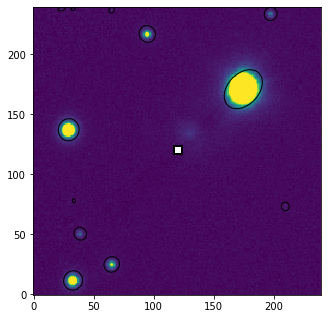

<Figure size 360x360 with 0 Axes>

In [52]:
fig = plt.figure(figsize=[5, 5])
ax = fig.add_axes([0.12, 0.12, 0.8, 0.8])

mmcls_lowz[i].show(ax=ax, ellipse=False, scaleup=2.5);
#ax.imshow(~mask_test)

#ax.set_xlim(200, 400)
#ax.set_ylim(100, 400)

#fig.savefig(f'../../../Images/pdf/cutouts/lowz_mass_cutout_size_{i}_set.pdf', bbox_inches='tight')

In [22]:
np.argmax(mmcls_lowz[i].ellipses[:, 2])

19

In [290]:
ell_sort = np.argsort(mmcls_lowz[i].ellipses[:, 2])[::-1]
ell_sizes = mmcls_lowz[i].ellipses[ell_sort][:, 2]
print(ell_sizes)
DLR_sorted = mmcls_lowz[i].DLR_list[ell_sort]
print(DLR_sorted)
np.where(mmcls_lowz[i].ellipses[:, 2] == ell_sizes[1])[0][0]

[75.45111084 17.04730988 14.33916759 14.30201054 10.01910686  6.91251278
  6.87993145  5.37841082  5.22313499  5.12937832  4.83417559  4.63904381
  4.48001528  4.16486597  4.10483646  4.05201244  3.9505198   3.9225502
  3.82659745  3.72961903  3.7176168   3.6931572   3.53563023  3.51059198
  3.49015975  3.42991209  3.3973      3.37732673  3.36408162  3.32433581
  3.31660271  3.21721148  3.18679929  3.16565394  3.14584708  3.13864541
  3.07651711  3.05067563  2.98213196  2.9262917   2.88260579  2.79914093
  2.75613952  2.74592257  2.72341728  2.71663117  2.67278361  2.64595008
  2.63572407  2.62398767  2.54309654  2.44091535  2.42974019  2.39854956
  2.37266302  2.36409497  2.36333752  2.33387375  2.32744336  2.31994414
  2.30025411  2.28489566  2.28391337  2.26215744  2.2407043   2.23231936
  2.23206186  2.22975349  2.22063541  2.19836998  2.19387412  2.17405462
  2.16596508  2.16341424  2.15864658  2.15459013  2.11638021  2.10913181
  2.10462594  2.05428147  2.02122092  2.01033425  1.

12

In [148]:
mmcls_lowz[i].update(size=400)

downloading BytesIO
downloading BytesIO
downloading BytesIO
downloading BytesIO
downloading BytesIO
downloading BytesIO
downloading BytesIO
downloading BytesIO
downloading BytesIO
downloading BytesIO


### Low-z sample mass calculation

In [9]:
lowz_mass = []
for i in range(len(ra)):
    #mm = massmeasure.MassMeasure(ra[i], dec[i], zcmb[i], pscls[i].imgcutout)
    mm = mmcls_lowz[i]
    lowz_mass.append(mm.hg_mass)

lowz_mass = np.asarray(lowz_mass)

In [298]:
pickle.dump(lowz_mass, open('../../../Data/lowz_mass', 'wb'))

In [3]:
with open('../../../Data/mass/lowz_mass', 'rb') as f:
    lowz_mass = pickle.load(f)

### SNf sample mass calculation

In [6]:
snf_mass = []
for i in range(len(ra)):
    #mm = massmeasure.MassMeasure(ra[i], dec[i], zcmb[i], pscls[i].imgcutout)
    mm = mmcls_snf[i]
    snf_mass.append(mm.hg_mass)

snf_mass = np.asarray(snf_mass)

In [7]:
pickle.dump(snf_mass, open('../../../Data/snf_mass', 'wb'))

In [5]:
with open('../../../Data/mass/snf_mass', 'rb') as f:
    snf_mass = pickle.load(f)

## `low-z` measured vs PS1 mass histogram

### Find closest PS1 catalog entry

In [32]:
p = panstarrs.PS1Target.from_coord(ra[i], dec[i])
p.download_catalog()

In [58]:
print(ra[i], dec[i])

7.46175 31.392744


In [3]:
with open('../../../Data/sne/lowz_df', 'rb') as f:
    lowz_df = pickle.load(f)

## Hist

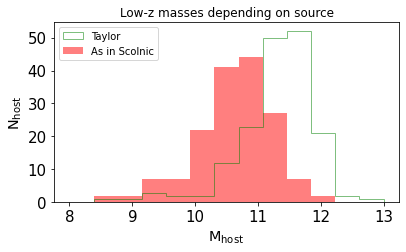

In [22]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])

nb_bins = 13

where = np.where(lowz_mass[:, 0] > 8)

#h, r = np.histogram(lowz_mass[:, 0][where],
#                    range=[8, 12], bins=nb_bins)
#xbin = np.mean([r[:-1], r[1:]], axis=0)

ax.hist(lowz_df['hg_mass_nr'],
        range=[8, 13], bins=nb_bins,
        histtype='step',
        color='g', alpha=.5,
        label='Taylor')
        
#ax.errorbar(xbin, h, yerr=np.array(
#    [lowz_mass[i][1:] for i in range(len(h))]).T,
#            marker="None", ls="None",
#            lw=1, alpha=.5,
#            ecolor='g')

ax.hist(lowz_df['hg_mass_sco'],
        range=[8, 13], bins=nb_bins,
        color=colors['low-z'], alpha=.5,
        label='As in Scolnic')

ax.tick_params(labelsize=15)

ax.set_xlabel(r"$\mathrm{M}_\mathrm{host}$", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{N}_\mathrm{host}$", fontsize="x-large")

ax.legend(loc='upper left')

plt.title('Low-z masses depending on source')

fig.savefig('../../../Images/pdf/lowz_comp_hist.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/lowz_comp_hist.png', bbox_inches='tight', dpi=600)

## Scatter

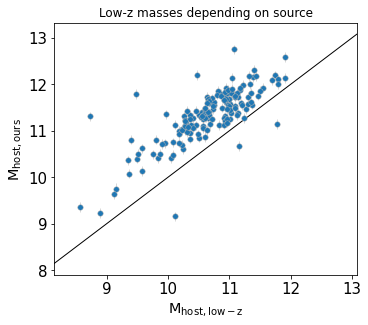

In [10]:
fig = plt.figure(figsize=[7, 7])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])

y_val = lowz_df['hg_mass_nr']
y_err = np.array([lowz_df['hg_masserr_nr_down'], lowz_df['hg_masserr_nr_up']])

x_val = lowz_df['hg_mass_sco']
x_err = lowz_df['hg_masserr_sco']

#ax.scatter(np.sort(np.concatenate((lowz_mass[:, 0], [5.0, 5.0]))),#[where],
#           np.sort(df.hostmass))

ax.scatter(x_val, y_val,
           marker='o', s=30,
           linewidths=.5,
           edgecolors='0.7',
           zorder=7)

ax.errorbar(x_val, y_val,
            yerr=y_err, #yerr=y_err,
            ecolor='0.7', alpha=1, ms=0,
            lw=.5, ls='none', label=None, zorder=5)

ax.tick_params(labelsize=15)

#ax.set_ylim(8, 12.5)
ax.set_xlim(ax.get_ylim())

ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [ax.get_xlim()[0], ax.get_xlim()[1]],
        lw=1, color='k', zorder=1)

ax.set_xlabel(r"$\mathrm{M}_\mathrm{host, low-z}$", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{M}_\mathrm{host, ours}$", fontsize="x-large")

#ax.legend()

plt.title('Low-z masses depending on source')

fig.savefig('../../../Images/pdf/lowz_comp_scatter.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/lowz_comp_scatter.png', bbox_inches='tight',
            dpi=600, transparent=False)

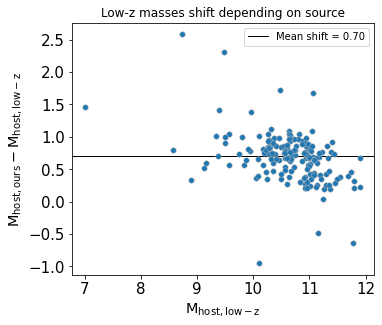

In [4]:
fig = plt.figure(figsize=[7, 7])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])

lowz_df_cut = lowz_df[lowz_df['hg_mass_sco'] > 5.]

y_val = lowz_df_cut['hg_mass_nr'] - lowz_df_cut['hg_mass_sco']
mean_shift = np.median(y_val)
#y_err = np.array([lowz_df['hg_masserr_nr_down'], lowz_df['hg_masserr_nr_up']])

x_val = lowz_df_cut['hg_mass_sco']
x_err = lowz_df_cut['hg_masserr_sco']

#ax.scatter(np.sort(np.concatenate((lowz_mass[:, 0], [5.0, 5.0]))),#[where],
#           np.sort(df.hostmass))

ax.scatter(x_val, y_val,
           marker='o', s=30,
           linewidths=.5,
           edgecolors='0.7',
           zorder=7)

#ax.errorbar(x_val, y_val,
#            yerr=y_err, #yerr=y_err,
#            ecolor='0.7', alpha=1, ms=0,
#            lw=.5, ls='none', label=None, zorder=5)

ax.axhline(mean_shift, color='k', lw=1, label=f'Mean shift = {mean_shift:.2f}')

ax.tick_params(labelsize=15)

#ax.set_ylim(8, 12.5)
#ax.set_xlim(ax.get_ylim())

#ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [ax.get_xlim()[0], ax.get_xlim()[1]],
#        lw=1, color='k', zorder=1)

ax.set_xlabel(r"$\mathrm{M}_\mathrm{host, low-z}$", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{M}_\mathrm{host, ours} - \mathrm{M}_\mathrm{host, low-z}$",
              fontsize="x-large")

ax.legend()

plt.title('Low-z masses shift depending on source')

fig.savefig('../../../Images/pdf/lowz_comp_shift.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/lowz_comp_shift.png', bbox_inches='tight',
            dpi=600, transparent=False)

In [69]:
np.unique(list(d[d['IDSURVEY'].isin([5, 61, 62, 63, 64, 65, 66])].HOST_LOGMASS_ERR > 1),
          return_counts=True)

(array([False,  True]), array([126,  46]))

## `SNf` measurements

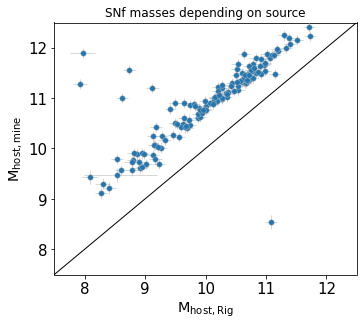

In [13]:
fig = plt.figure(figsize=[7, 7])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])

y_val = snf_mass[:,0]#[select_recons][1:]
y_err = np.array([snf_mass[i,1:] for i in range(len(y_val))]).T

rig_mass = d_snf['gmass'].values
rig_masserr = np.array([np.asarray(d_snf['gmass.err_down']),
                        np.asarray(d_snf['gmass.err_up'])]).T
x_val = rig_mass
x_err = rig_masserr

#ax.scatter(np.sort(np.concatenate((lowz_mass[:, 0], [5.0, 5.0]))),#[where],
#           np.sort(df.hostmass))

ax.scatter(x_val, y_val,
           marker='o', s=30,
           linewidths=.5,
           edgecolors='0.7',
           zorder=7)

ax.errorbar(x_val, y_val,
            xerr=x_err.T, yerr=y_err,
            ecolor='0.7', alpha=1, ms=0,
            lw=.5, ls='none', label=None, zorder=5)

ax.tick_params(labelsize=15)

ax.set_ylim(7.5, 12.5)
ax.set_xlim(ax.get_ylim())

ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [ax.get_xlim()[0], ax.get_xlim()[1]],
        lw=1, color='k', zorder=1)

ax.set_xlabel(r"$\mathrm{M}_\mathrm{host, Rig}$", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{M}_\mathrm{host, mine}$", fontsize="x-large")

#ax.legend()

plt.title('SNf masses depending on source')

fig.savefig('../../../Images/pdf/snf_comp_scatter.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/snf_comp_scatter.png', bbox_inches='tight',
            dpi=600, transparent=False)

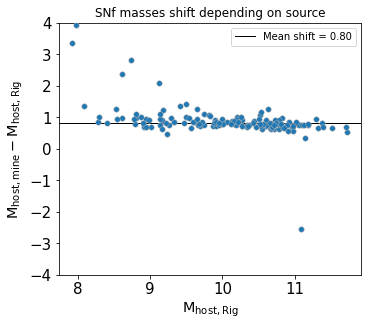

In [12]:
fig = plt.figure(figsize=[7, 7])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])

y_val = snf_mass[:,0]#[select_recons][1:]
y_err = np.array([snf_mass[i,1:] for i in range(len(y_val))]).T

rig_mass = d_snf['gmass'].values
rig_masserr = np.array([np.asarray(d_snf['gmass.err_down']),
                        np.asarray(d_snf['gmass.err_up'])]).T
x_val = rig_mass
x_err = rig_masserr

y_val = y_val-x_val
mean_shift = np.median(y_val)

#ax.scatter(np.sort(np.concatenate((lowz_mass[:, 0], [5.0, 5.0]))),#[where],
#           np.sort(df.hostmass))

ax.scatter(x_val, y_val,
           marker='o', s=30,
           linewidths=.5,
           edgecolors='0.7',
           zorder=7)

#ax.errorbar(x_val, y_val,
#            xerr=x_err.T, yerr=y_err,
#            ecolor='0.7', alpha=1, ms=0,
#            lw=.5, ls='none', label=None, zorder=5)

ax.axhline(mean_shift, color='k', lw=1, label=f'Mean shift = {mean_shift:.2f}')

ax.tick_params(labelsize=15)

ax.set_ylim(-4, 4)
#ax.set_xlim(ax.get_ylim())

#ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [ax.get_xlim()[0], ax.get_xlim()[1]],
#        lw=1, color='k', zorder=1)

ax.set_xlabel(r"$\mathrm{M}_\mathrm{host, Rig}$",
              fontsize="x-large")
ax.set_ylabel(r"$\mathrm{M}_\mathrm{host, mine} - \mathrm{M}_\mathrm{host, Rig}$",
              fontsize="x-large")

ax.legend()

plt.title('SNf masses shift depending on source')

fig.savefig('../../../Images/pdf/snf_comp_shift.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/snf_comp_shift.png', bbox_inches='tight',
            dpi=600, transparent=False)